# Brain Tumor Detection

### Part 1. **資料探索與清理**
   - 資料集基本資訊
   - 標註分析
   - 問題圖片識別
   - 資料清理

### Part2. **模型訓練流程**
   - 環境設置
   - 資料增強
   - Dataset 和 DataLoader
   - U-Net 模型
   - 訓練與驗證
   - 測試與視覺化


## Part 1: 資料探索與清理

1. 載入 Train/Valid/Test 的 COCO JSON 檔。
2. 分析並移除異常資料（無標註或重複標註的圖片）。
3. 儲存清理後的 JSON 檔。
4. 隨機顯示 3 張訓練集圖片及其遮罩以供檢查。


==================== Data Cleaning Report ====================

[TRAIN] Found issues:
  - Multi-annotated IDs: [1005]
  - No-annotation IDs: [1380]
  - Removed 2 images.
  - Saved cleaned to: ./train/_annotations.coco.cleaned.json

[VALID] No issues found. Saving copy for consistency.

[TEST] No issues found. Saving copy for consistency.

==================== Visualization (Train Samples) ====================


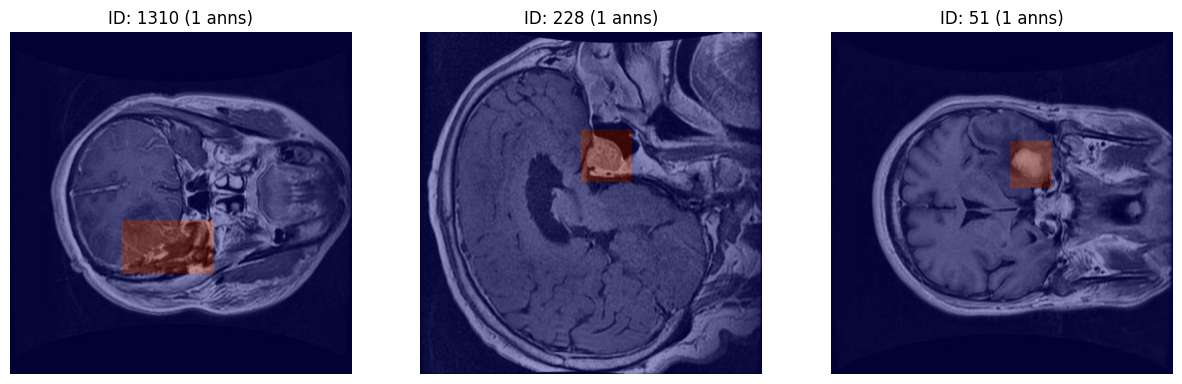

In [10]:
import json
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def clean_and_analyze_data():
    """
    分析並清理腦腫瘤分割資料集 (COCO 格式)。
    1. 識別無標註或多重標註的圖片。
    2. 移除異常圖片。
    3. 儲存清理後的 JSON 檔。
    4. 視覺化訓練集樣本。
    """
    
    datasets = ['train', 'valid', 'test']
    
    print(f"{'='*20} Data Cleaning Report {'='*20}")
    
    for split in datasets:
        json_path = os.path.join('.', split, '_annotations.coco.json')
        output_path = os.path.join('.', split, '_annotations.coco.cleaned.json')
        
        if not os.path.exists(json_path):
            print(f"[Warn] {json_path} not found.")
            continue
            
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
        images = data.get('images', [])
        annotations = data.get('annotations', [])
        
        # 分析標註數量：統計每張圖片對應的標註數
        img_ann_counts = defaultdict(int)
        for ann in annotations:
            img_ann_counts[ann['image_id']] += 1
            
        # 識別異常 ID
        ids_to_remove = set()
        
        # 情況 1：多重標註 (若邏輯上嚴格限制一張圖僅能有一個標註)
        multi_ann_ids = [img_id for img_id, count in img_ann_counts.items() if count > 1]
        ids_to_remove.update(multi_ann_ids)
        
        # 情況 2：無標註圖片
        all_img_ids = {img['id'] for img in images}
        annotated_img_ids = set(img_ann_counts.keys())
        no_ann_ids = all_img_ids - annotated_img_ids
        ids_to_remove.update(no_ann_ids)
        
        # 執行資料清理
        if ids_to_remove:
            print(f"\n[{split.upper()}] Found issues:")
            if multi_ann_ids: print(f"  - Multi-annotated IDs: {multi_ann_ids}")
            if no_ann_ids: print(f"  - No-annotation IDs: {list(no_ann_ids)}")
            
            # 過濾掉異常的圖片與標註
            new_images = [img for img in images if img['id'] not in ids_to_remove]
            new_anns = [ann for ann in annotations if ann['image_id'] not in ids_to_remove]
            
            data['images'] = new_images
            data['annotations'] = new_anns
            
            print(f"  - Removed {len(images) - len(new_images)} images.")
            print(f"  - Saved cleaned to: {output_path}")
            
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=4)
        else:
            print(f"\n[{split.upper()}] No issues found. Saving copy for consistency.")
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=4)

    print(f"\n{'='*20} Visualization (Train Samples) {'='*20}")
    
    # 從訓練集隨機抽取樣本進行視覺化檢查
    train_clean_path = os.path.join('.', 'train', '_annotations.coco.cleaned.json')
    if os.path.exists(train_clean_path):
        with open(train_clean_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        if not data['images']:
            print("No images to display.")
            return

        sample_imgs = random.sample(data['images'], min(3, len(data['images'])))
        
        plt.figure(figsize=(15, 5))
        for idx, img_info in enumerate(sample_imgs):
            img_path = os.path.join('.', 'train', img_info['file_name'])
            if not os.path.exists(img_path): continue
                
            # 讀取並轉換圖片色彩空間 (BGR -> RGB)
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # 建立遮罩 (Mask)
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            img_anns = [ann for ann in data['annotations'] if ann['image_id'] == img_info['id']]
            for ann in img_anns:
                if 'segmentation' in ann:
                     # 處理多邊形標註 (Polygon) 並填充至遮罩
                     for seg in ann['segmentation']:
                        poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                        cv2.fillPoly(mask, [poly], 1)
            
            # 繪圖
            plt.subplot(1, 3, idx+1)
            plt.imshow(img)
            plt.imshow(mask, alpha=0.4, cmap='jet') # 疊加半透明遮罩
            plt.title(f"ID: {img_info['id']} ({len(img_anns)} anns)")
            plt.axis('off')
        plt.show()

# 執行清理流程
clean_and_analyze_data()

## Part 2: 模型訓練與評估

整合同環境設置、資料增強、模型建構與訓練評估流程。



In [11]:
import os
import gc
import json
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.nn as nn

# 系統設定
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# 設定計算裝置：優先使用 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 在主程式一開始呼叫
seed_everything(42)

Device: cuda
GPU: NVIDIA GeForce RTX 4090


In [12]:
def get_transforms(image_size=640):
    """定義訓練集與驗證集的資料增強策略"""
    return {
        "train": A.Compose([
            A.Resize(image_size, image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussianBlur(p=0.2),
            A.ElasticTransform(alpha=1, sigma=50, p=0.2), # 彈性變形，增加模型強健性
            A.Normalize(),
            ToTensorV2()
        ]),
        "valid": A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(),
            ToTensorV2()
        ])
    }

# =============================================================================
# 自定義資料集類別：負責讀取影像與 COCO 格式的遮罩
# =============================================================================
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = Path(image_dir)
        self.transform = transform
        
        # 讀取標註檔
        try:
            with open(annotation_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
        except Exception:
            # 若清理後的檔案不存在，嘗試讀取原始檔案
            if 'cleaned' in annotation_file:
                alt_file = annotation_file.replace('.cleaned.json', '.json')
                with open(alt_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
            else: raise

        # 建立 ID 到圖片資訊與標註的映射
        self.images = {img['id']: img for img in data['images']}
        self.image_to_anns = defaultdict(list)
        for ann in data['annotations']:
            self.image_to_anns[ann['image_id']].append(ann)
        self.image_ids = list(self.images.keys())

    def __len__(self): 
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        info = self.images[image_id]
        img_path = self.image_dir / info['file_name']
        
        # 讀取圖片
        image = cv2.imread(str(img_path))
        if image is None: # 若圖片遺失，建立全黑圖片以防報錯
             image = np.zeros((info['height'], info['width'], 3), dtype=np.uint8)
        else:
             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
             
        # 建立遮罩 (將所有多邊形標註繪製到同一張遮罩上)
        mask = np.zeros((info['height'], info['width']), dtype=np.uint8)
        for ann in self.image_to_anns[image_id]:
            if 'segmentation' in ann:
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape(-1, 2).astype(np.int32)
                    cv2.fillPoly(mask, [poly], 1)
        
        # 應用資料增強
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            mask = torch.from_numpy(mask).unsqueeze(0).float()
            
        return image, mask

def get_loaders(batch_size=16, num_workers=4):
    """建立 Train/Valid/Test 的 DataLoader"""
    transforms = get_transforms()
    loaders = {}
    for split in ['train', 'valid', 'test']:
        ann_file = f'./{split}/_annotations.coco.cleaned.json'
        if not os.path.exists(ann_file): 
            ann_file = f'./{split}/_annotations.coco.json'
            
        ds = BrainTumorDataset(
            image_dir=f'./{split}', 
            annotation_file=ann_file,
            transform=transforms['train'] if split == 'train' else transforms['valid']
        )
        
        loaders[split] = DataLoader(
            ds, 
            batch_size=batch_size if split != 'test' else 1, 
            shuffle=(split == 'train'), 
            num_workers=num_workers,
            pin_memory=True # 加速主機到 GPU 的資料傳輸
        )
    return loaders['train'], loaders['valid'], loaders['test']

In [13]:
def build_model():
    """建立 U-Net++ 模型，使用 ResNet34 作為編碼器 (Encoder)"""
    return smp.UnetPlusPlus(
        encoder_name="resnet34", 
        encoder_weights="imagenet", 
        in_channels=3, 
        classes=1
    )

focal_loss_fn = smp.losses.FocalLoss(mode='binary', alpha=0.8, gamma=2.0)
dice_loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)
def combined_loss(pred, target):
    """
    結合 Focal Loss 與 Dice Loss
    Focal Loss: 專注於難分類的像素 (解決類別不平衡)
    Dice Loss: 專注於重疊區域 (分割任務核心指標)
    """
    if target.dim() != pred.dim(): 
        target = target.unsqueeze(1)
    
    # 確保 target 是 float 類型
    target = target.float()
    
    # 計算 Focal Loss (輸入是 logits，不需要先做 sigmoid，函數內部會處理)
    focal = focal_loss_fn(pred, target)
    
    # 計算 Dice Loss (輸入是 logits，函數內部會做 sigmoid)
    dice = dice_loss_fn(pred, target)
    
    # 權重組合：
    return 0.5 * focal + 0.5 * dice

def calculate_metrics(pred, target, threshold=0.5):
    """
    計算評估指標，支援自訂閾值
    """
    # 將預測結果轉為二值化 (根據傳入的 threshold)
    pred_bin = (torch.sigmoid(pred) > threshold).float()
    
    if target.dim() != pred.dim(): 
        target = target.unsqueeze(1)
    target = target.float()
    
    # 計算 TP, FP, FN, TN
    tp = (pred_bin * target).sum()
    fp = (pred_bin * (1 - target)).sum()
    fn = ((1 - pred_bin) * target).sum()
    tn = ((1 - pred_bin) * (1 - target)).sum() # 新增: True Negative
    
    smooth = 1e-7
    
    # 計算各項指標
    dice = (2. * tp) / (2. * tp + fp + fn + smooth)
    iou = tp / (tp + fp + fn + smooth)
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    f1 = (2. * precision * recall) / (precision + recall + smooth)
    accuracy = (tp + tn) / (tp + tn + fp + fn + smooth)
    
    return dice.item(), iou.item(), precision.item(), recall.item(), f1.item(), accuracy.item()

def train_eval_loop(model, train_loader, valid_loader, epochs=100, patience=15):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience=5)
    scaler = GradScaler()
    
    best_dice = 0
    patience_counter = 0
    
    # 初始化紀錄字典
    history = {
        'train_loss': [],
        'train_dice': [],
        'valid_loss': [],
        'valid_dice': [],
        'valid_iou': [],
        'lr': []
    }
    
    print(f"Start training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # ------ 訓練階段 ------
        model.train()
        train_loss = 0
        train_dice_sum = 0
        
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} Train", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(imgs)
                loss = combined_loss(outputs, masks)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            
            # 計算訓練集的 Dice
            with torch.no_grad():
                d, _, _, _, _, _ = calculate_metrics(outputs, masks)
                train_dice_sum += d
            
        # ------ 驗證階段 ------
        model.eval()
        val_loss = 0
        val_dice_sum, val_iou_sum = 0, 0
        
        with torch.no_grad():
            for imgs, masks in tqdm(valid_loader, desc=f"Epoch {epoch+1} Valid", leave=False):
                imgs, masks = imgs.to(device), masks.to(device)
                with autocast():
                    outputs = model(imgs)
                    loss = combined_loss(outputs, masks)
                
                val_loss += loss.item()
                
                # 修正：正確接收 5 個回傳值，只取前兩個 (Dice, IoU)
                d, i, _, _, _, _ = calculate_metrics(outputs, masks)
                val_dice_sum += d
                val_iou_sum += i
        
        # 計算平均值
        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice_sum / len(train_loader)
        avg_val_loss = val_loss / len(valid_loader)
        avg_val_dice = val_dice_sum / len(valid_loader)
        avg_iou = val_iou_sum / len(valid_loader)
        current_lr = optimizer.param_groups[0]['lr']
        
        # 記錄到 history
        history['train_loss'].append(avg_train_loss)
        history['train_dice'].append(avg_train_dice)
        history['valid_loss'].append(avg_val_loss)
        history['valid_dice'].append(avg_val_dice)
        history['valid_iou'].append(avg_iou)
        history['lr'].append(current_lr)
        
        # 列印資訊
        print(f"\nEpoch {epoch+1}:")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}")
        print(f"Valid Loss: {avg_val_loss:.4f}, Valid Dice: {avg_val_dice:.4f}")
        print(f"Learning Rate: {current_lr:.10f}")
        
        scheduler.step(avg_val_dice)
        
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            torch.save(model.state_dict(), "best_model.pth")
            print(f"✓ Saved best model (valid Dice: {best_dice:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    
    return history

In [14]:
def plot_training_history(history):
    """繪製 Loss, Dice, IoU 和 Learning Rate 的變化曲線"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # 1. Loss Curve (Train & Valid)
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'r-', label='Train Loss')
    plt.plot(epochs, history['valid_loss'], 'b--', label='Valid Loss') 
    
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # 2. Metrics Curve (Dice & IoU)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['valid_dice'], 'b-', label='Valid Dice')
    plt.plot(epochs, history['valid_iou'], 'g--', label='Valid IoU')
    plt.title('Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    
    # 3. Learning Rate Curve
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['lr'], 'm-')
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('LR')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [15]:
def find_best_threshold(model, loader, device):
    """
    在驗證集上搜尋最佳閾值 (範圍 0.3 ~ 0.7)
    """
    model.eval()
    
    # 設定要搜尋的閾值範圍 (0.30 到 0.70，間隔 0.05)
    thresholds = np.arange(0.3, 0.75, 0.05)
    best_thr = 0.5
    best_dice = 0.0
    
    print("Searching for best threshold on Validation Set...")
    
    # 為了加速，先收集所有預測結果與標籤
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Inference", leave=False):
            imgs = imgs.to(device)
            outputs = model(imgs)
            # 存下 sigmoid 後的機率值
            all_preds.append(torch.sigmoid(outputs).cpu())
            all_targets.append(masks.cpu())
            
    # 合併成大 Tensor
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    # 確保維度一致
    if all_targets.dim() != all_preds.dim():
        all_targets = all_targets.unsqueeze(1)
        
    # 開始迴圈搜尋
    print(f"{'Threshold':<15} {'Dice Score':<15}")
    print("-" * 30)
    
    for thr in thresholds:
        # 快速計算 Dice (向量化操作，不需 loop)
        pred_bin = (all_preds > thr).float()
        
        tp = (pred_bin * all_targets).sum()
        fp = (pred_bin * (1 - all_targets)).sum()
        fn = ((1 - pred_bin) * all_targets).sum()
        smooth = 1e-7
        
        dice_val = (2. * tp) / (2. * tp + fp + fn + smooth)
        dice_val = dice_val.item()
        
        print(f"{thr:<15.2f} {dice_val:<15.4f}")
        
        if dice_val > best_dice:
            best_dice = dice_val
            best_thr = thr
            
    print("-" * 30)
    print(f"Best Threshold found: {best_thr:.2f} (Val Dice: {best_dice:.4f})")
    return best_thr

In [16]:
def evaluate_test_set(model, test_loader, threshold=0.5):
    """
    使用指定閾值評估測試集
    """
    model.eval()
    
    # 初始化累加器
    metrics_sum = defaultdict(float)
    
    print(f"Evaluating on Test Set (Threshold: {threshold:.2f})...")
    
    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc="Testing", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            
            # 傳入最佳閾值進行計算 (接收 6 個回傳值)
            d, i, p, r, f, acc = calculate_metrics(outputs, masks, threshold=threshold)
            
            metrics_sum['dice'] += d
            metrics_sum['iou'] += i
            metrics_sum['precision'] += p
            metrics_sum['recall'] += r
            metrics_sum['f1'] += f
            metrics_sum['accuracy'] += acc # 累加 Accuracy
    
    # 計算平均值
    num_batches = len(test_loader)
    avg_metrics = {k: v / num_batches for k, v in metrics_sum.items()}
    
    print(f"\n{'='*30}")
    print(f"Test Set Results (Thr={threshold:.2f}):")
    print(f"Mean Dice Score : {avg_metrics['dice']:.4f}")
    print(f"Mean IoU Score  : {avg_metrics['iou']:.4f}")
    print(f"Mean Precision  : {avg_metrics['precision']:.4f}")
    print(f"Mean Recall     : {avg_metrics['recall']:.4f}")
    print(f"Mean F1 Score   : {avg_metrics['f1']:.4f}")
    print(f"Mean Accuracy   : {avg_metrics['accuracy']:.4f}") # 顯示 Accuracy
    print(f"{'='*30}\n")
    
    return avg_metrics

In [17]:
def visualize_predictions(model, dataset, device, num_samples=5, threshold=0.5):
    """
    視覺化預測結果 (使用最佳閾值進行二值化顯示)
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    indices = random.sample(range(len(dataset)), num_samples)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx]
            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            
            # 使用最佳閾值產生預測遮罩 (0 或 1)
            pred_prob = torch.sigmoid(output).cpu().squeeze().numpy()
            pred_mask = (pred_prob > threshold).astype(np.float32)
            
            # 圖像反正規化
            image_np = image.cpu().numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = image_np * std + mean
            image_np = np.clip(image_np, 0, 1)
            
            mask_np = mask.cpu().squeeze().numpy()
            
            # 繪圖
            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title(f'ID: {dataset.image_ids[idx]}')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_mask, cmap='gray')
            axes[i, 2].set_title(f'Prediction (Thr={threshold:.2f})')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(image_np)
            axes[i, 3].imshow(pred_mask, cmap='jet', alpha=0.5)
            axes[i, 3].set_title('Overlay')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2647642/2910671922.py:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Initializing Data Loaders...
Building Model...
Starting Training...
Start training for 100 epochs...


Epoch 1 Train:   0%|          | 0/94 [00:00<?, ?it/s]/tmp/ipykernel_2647642/2910671922.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Valid:   0%|          | 0/27 [00:00<?, ?it/s]         /tmp/ipykernel_2647642/2910671922.py:115: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1:
Train Loss: 0.4045, Train Dice: 0.4381
Valid Loss: 0.3572, Valid Dice: 0.5478
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.5478)



Epoch 2:
Train Loss: 0.3201, Train Dice: 0.6494
Valid Loss: 0.2996, Valid Dice: 0.6626
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.6626)



Epoch 3:
Train Loss: 0.2574, Train Dice: 0.7011
Valid Loss: 0.2342, Valid Dice: 0.6914
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.6914)



Epoch 4:
Train Loss: 0.2060, Train Dice: 0.7420
Valid Loss: 0.1921, Valid Dice: 0.7506
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.7506)



Epoch 5:
Train Loss: 0.1797, Train Dice: 0.7548
Valid Loss: 0.1676, Valid Dice: 0.7692
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.7692)



Epoch 6:
Train Loss: 0.1589, Train Dice: 0.7724
Valid Loss: 0.1619, Valid Dice: 0.7569
Learning Rate: 0.0001000000



Epoch 7:
Train Loss: 0.1465, Train Dice: 0.7809
Valid Loss: 0.1515, Valid Dice: 0.7715
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.7715)



Epoch 8:
Train Loss: 0.1296, Train Dice: 0.8034
Valid Loss: 0.1514, Valid Dice: 0.7591
Learning Rate: 0.0001000000



Epoch 9:
Train Loss: 0.1250, Train Dice: 0.8054
Valid Loss: 0.1359, Valid Dice: 0.7850
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.7850)



Epoch 10:
Train Loss: 0.1182, Train Dice: 0.8145
Valid Loss: 0.1350, Valid Dice: 0.7849
Learning Rate: 0.0001000000



Epoch 11:
Train Loss: 0.1126, Train Dice: 0.8210
Valid Loss: 0.1392, Valid Dice: 0.7746
Learning Rate: 0.0001000000



Epoch 12:
Train Loss: 0.1122, Train Dice: 0.8194
Valid Loss: 0.1447, Valid Dice: 0.7628
Learning Rate: 0.0001000000



Epoch 13:
Train Loss: 0.1065, Train Dice: 0.8274
Valid Loss: 0.1311, Valid Dice: 0.7830
Learning Rate: 0.0001000000



Epoch 14:
Train Loss: 0.1061, Train Dice: 0.8267
Valid Loss: 0.1372, Valid Dice: 0.7762
Learning Rate: 0.0001000000



Epoch 15:
Train Loss: 0.1026, Train Dice: 0.8318
Valid Loss: 0.1273, Valid Dice: 0.7892
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.7892)



Epoch 16:
Train Loss: 0.0966, Train Dice: 0.8414
Valid Loss: 0.1303, Valid Dice: 0.7892
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.7892)



Epoch 17:
Train Loss: 0.0941, Train Dice: 0.8450
Valid Loss: 0.1243, Valid Dice: 0.7954
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.7954)



Epoch 18:
Train Loss: 0.0919, Train Dice: 0.8478
Valid Loss: 0.1295, Valid Dice: 0.7888
Learning Rate: 0.0001000000



Epoch 19:
Train Loss: 0.0900, Train Dice: 0.8507
Valid Loss: 0.1189, Valid Dice: 0.8043
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.8043)



Epoch 20:
Train Loss: 0.0856, Train Dice: 0.8578
Valid Loss: 0.1233, Valid Dice: 0.7935
Learning Rate: 0.0001000000



Epoch 21:
Train Loss: 0.0905, Train Dice: 0.8481
Valid Loss: 0.1296, Valid Dice: 0.7848
Learning Rate: 0.0001000000



Epoch 22:
Train Loss: 0.0881, Train Dice: 0.8534
Valid Loss: 0.1139, Valid Dice: 0.8120
Learning Rate: 0.0001000000
✓ Saved best model (valid Dice: 0.8120)



Epoch 23:
Train Loss: 0.0904, Train Dice: 0.8488
Valid Loss: 0.1286, Valid Dice: 0.7856
Learning Rate: 0.0001000000



Epoch 24:
Train Loss: 0.0835, Train Dice: 0.8600
Valid Loss: 0.1244, Valid Dice: 0.7947
Learning Rate: 0.0001000000



Epoch 25:
Train Loss: 0.0839, Train Dice: 0.8591
Valid Loss: 0.1252, Valid Dice: 0.7940
Learning Rate: 0.0001000000



Epoch 26:
Train Loss: 0.0794, Train Dice: 0.8669
Valid Loss: 0.1225, Valid Dice: 0.7947
Learning Rate: 0.0001000000



Epoch 27:
Train Loss: 0.0822, Train Dice: 0.8616
Valid Loss: 0.1255, Valid Dice: 0.7943
Learning Rate: 0.0001000000



Epoch 28:
Train Loss: 0.0777, Train Dice: 0.8695
Valid Loss: 0.1225, Valid Dice: 0.7969
Learning Rate: 0.0001000000



Epoch 29:
Train Loss: 0.0707, Train Dice: 0.8809
Valid Loss: 0.1165, Valid Dice: 0.8071
Learning Rate: 0.0000100000



Epoch 30:
Train Loss: 0.0668, Train Dice: 0.8877
Valid Loss: 0.1151, Valid Dice: 0.8102
Learning Rate: 0.0000100000



Epoch 31:
Train Loss: 0.0669, Train Dice: 0.8878
Valid Loss: 0.1149, Valid Dice: 0.8095
Learning Rate: 0.0000100000



Epoch 32:
Train Loss: 0.0656, Train Dice: 0.8898
Valid Loss: 0.1149, Valid Dice: 0.8104
Learning Rate: 0.0000100000



Epoch 33:
Train Loss: 0.0646, Train Dice: 0.8914
Valid Loss: 0.1136, Valid Dice: 0.8121
Learning Rate: 0.0000100000
✓ Saved best model (valid Dice: 0.8121)



Epoch 34:
Train Loss: 0.0640, Train Dice: 0.8924
Valid Loss: 0.1126, Valid Dice: 0.8137
Learning Rate: 0.0000100000
✓ Saved best model (valid Dice: 0.8137)



Epoch 35:
Train Loss: 0.0624, Train Dice: 0.8954
Valid Loss: 0.1128, Valid Dice: 0.8139
Learning Rate: 0.0000100000
✓ Saved best model (valid Dice: 0.8139)



Epoch 36:
Train Loss: 0.0619, Train Dice: 0.8957
Valid Loss: 0.1126, Valid Dice: 0.8147
Learning Rate: 0.0000100000
✓ Saved best model (valid Dice: 0.8147)



Epoch 37:
Train Loss: 0.0615, Train Dice: 0.8968
Valid Loss: 0.1122, Valid Dice: 0.8146
Learning Rate: 0.0000100000



Epoch 38:
Train Loss: 0.0610, Train Dice: 0.8976
Valid Loss: 0.1125, Valid Dice: 0.8147
Learning Rate: 0.0000100000
✓ Saved best model (valid Dice: 0.8147)



Epoch 39:
Train Loss: 0.0615, Train Dice: 0.8966
Valid Loss: 0.1124, Valid Dice: 0.8145
Learning Rate: 0.0000100000



Epoch 40:
Train Loss: 0.0602, Train Dice: 0.8988
Valid Loss: 0.1156, Valid Dice: 0.8101
Learning Rate: 0.0000100000



Epoch 41:
Train Loss: 0.0591, Train Dice: 0.9007
Valid Loss: 0.1164, Valid Dice: 0.8092
Learning Rate: 0.0000100000



Epoch 42:
Train Loss: 0.0595, Train Dice: 0.9002
Valid Loss: 0.1157, Valid Dice: 0.8101
Learning Rate: 0.0000100000



Epoch 43:
Train Loss: 0.0580, Train Dice: 0.9026
Valid Loss: 0.1151, Valid Dice: 0.8111
Learning Rate: 0.0000010000



Epoch 44:
Train Loss: 0.0596, Train Dice: 0.8998
Valid Loss: 0.1145, Valid Dice: 0.8118
Learning Rate: 0.0000010000



Epoch 45:
Train Loss: 0.0578, Train Dice: 0.9027
Valid Loss: 0.1142, Valid Dice: 0.8125
Learning Rate: 0.0000010000



Epoch 46:
Train Loss: 0.0571, Train Dice: 0.9039
Valid Loss: 0.1137, Valid Dice: 0.8131
Learning Rate: 0.0000010000



Epoch 47:
Train Loss: 0.0578, Train Dice: 0.9031
Valid Loss: 0.1132, Valid Dice: 0.8138
Learning Rate: 0.0000010000



Epoch 48:
Train Loss: 0.0581, Train Dice: 0.9023
Valid Loss: 0.1129, Valid Dice: 0.8145
Learning Rate: 0.0000010000



Epoch 49:
Train Loss: 0.0575, Train Dice: 0.9035
Valid Loss: 0.1140, Valid Dice: 0.8130
Learning Rate: 0.0000001000



Epoch 50:
Train Loss: 0.0580, Train Dice: 0.9026
Valid Loss: 0.1135, Valid Dice: 0.8139
Learning Rate: 0.0000001000



Epoch 51:
Train Loss: 0.0581, Train Dice: 0.9025
Valid Loss: 0.1135, Valid Dice: 0.8136
Learning Rate: 0.0000001000



Epoch 52:
Train Loss: 0.0566, Train Dice: 0.9048
Valid Loss: 0.1139, Valid Dice: 0.8131
Learning Rate: 0.0000001000



Epoch 53:
Train Loss: 0.0576, Train Dice: 0.9033
Valid Loss: 0.1136, Valid Dice: 0.8135
Learning Rate: 0.0000001000
Early stopping triggered.
Training finished.


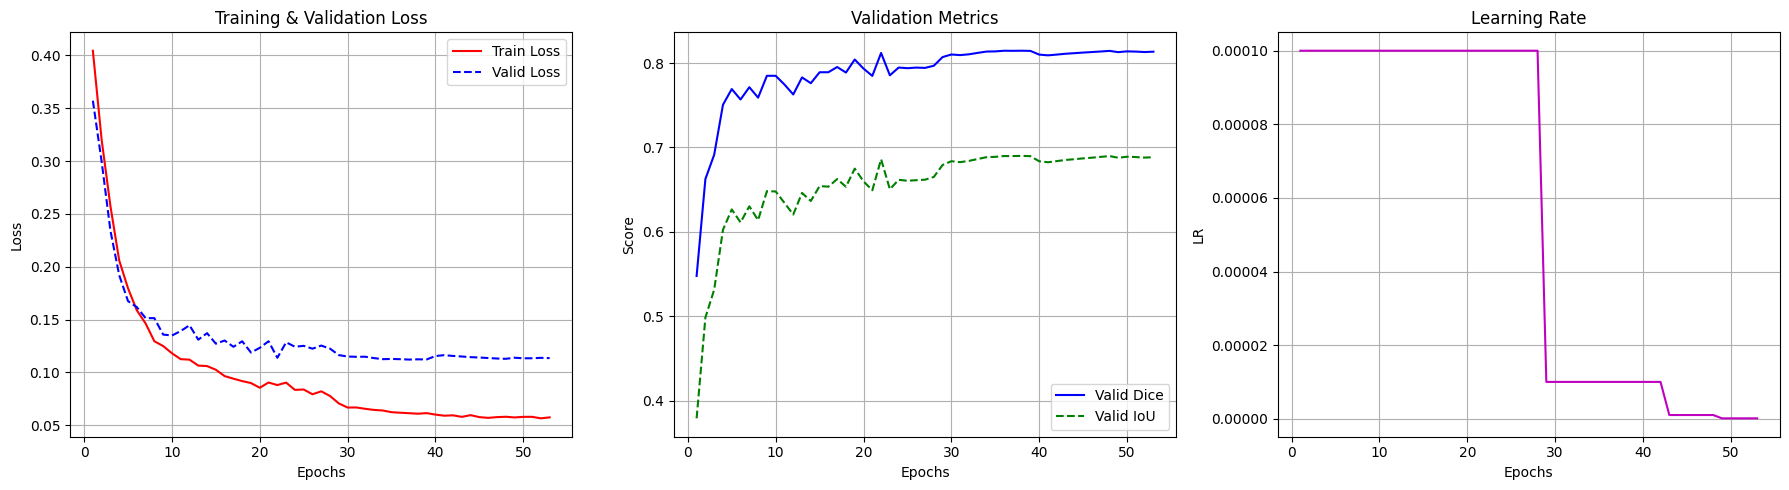


Loading best model weights...
Searching for best threshold on Validation Set...


Threshold       Dice Score     
------------------------------
0.30            0.8145         
0.35            0.8146         
0.40            0.8146         
0.45            0.8146         
0.50            0.8147         
0.55            0.8146         
0.60            0.8146         
0.65            0.8145         
0.70            0.8144         
------------------------------
Best Threshold found: 0.50 (Val Dice: 0.8147)
Evaluating on Test Set (Threshold: 0.50)...



Test Set Results (Thr=0.50):
Mean Dice Score : 0.8106
Mean IoU Score  : 0.7141
Mean Precision  : 0.8268
Mean Recall     : 0.8447
Mean F1 Score   : 0.8106
Mean Accuracy   : 0.9870


Visualizing Predictions with optimized threshold...


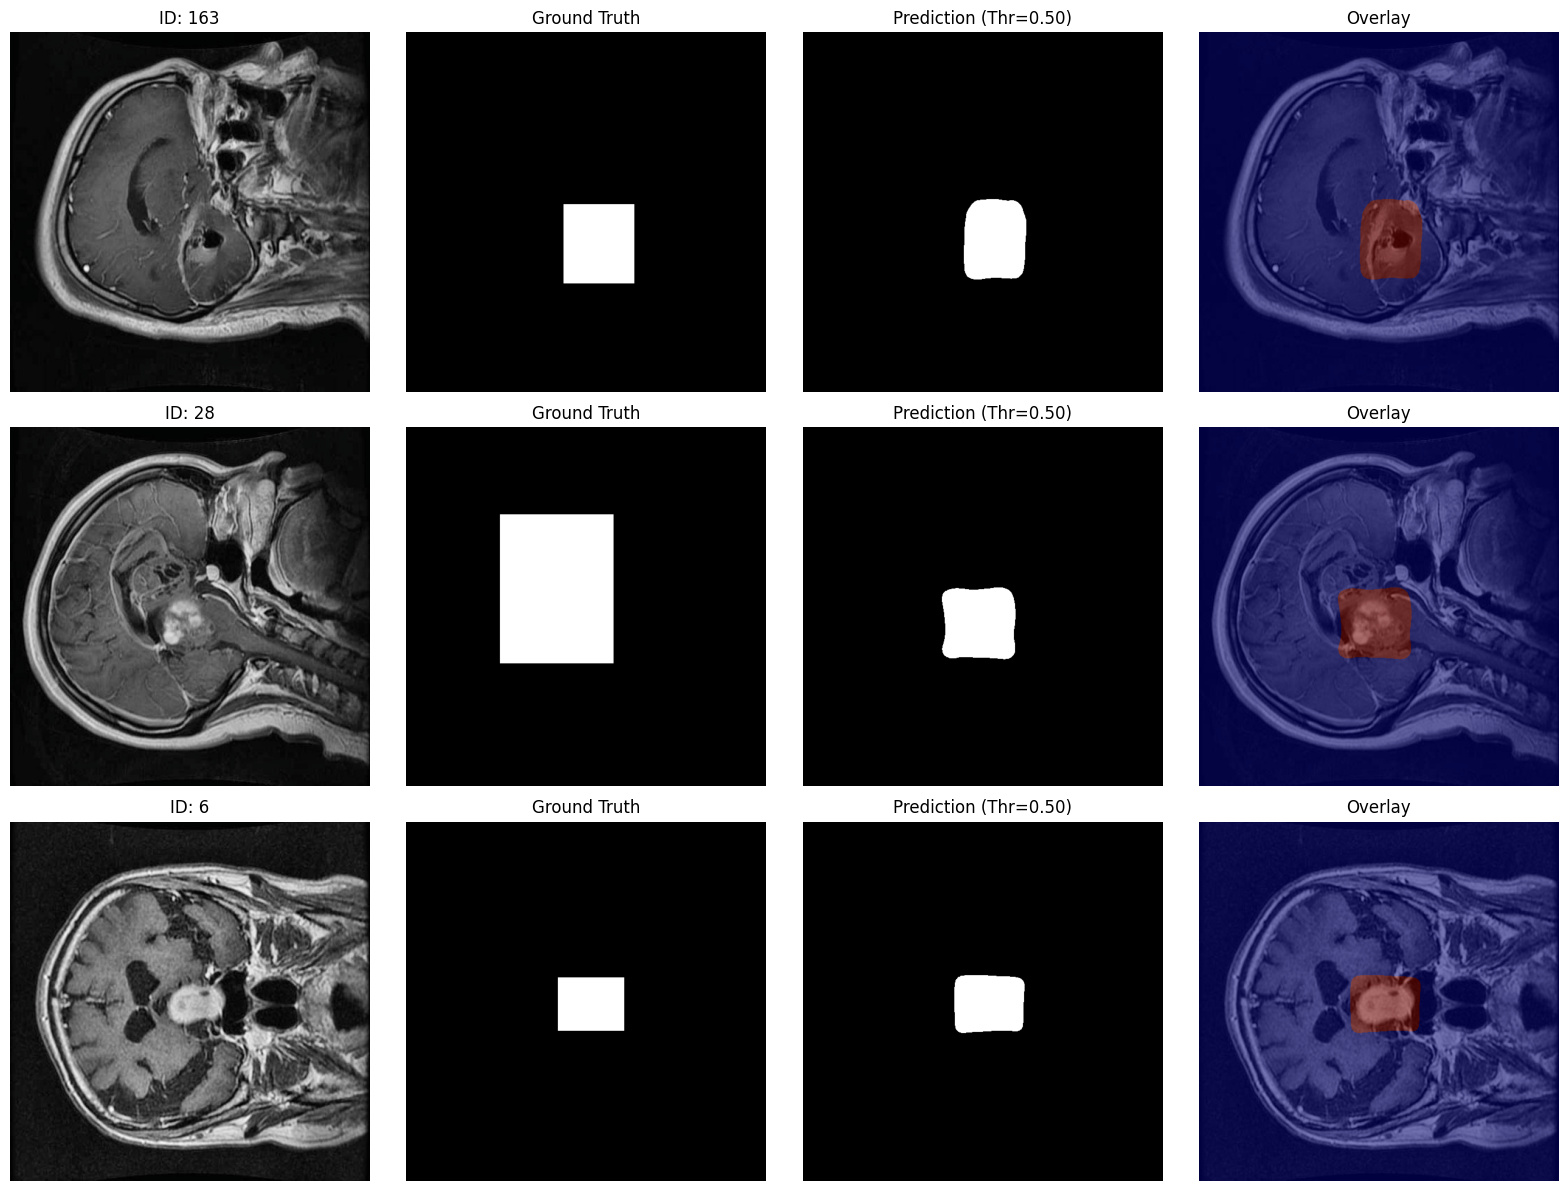

In [18]:
try:
    # 1. 準備資料
    print("Initializing Data Loaders...")
    train_loader, valid_loader, test_loader = get_loaders(batch_size=16, num_workers=4)
    
    # 2. 建立模型
    print("Building Model...")
    model = build_model().to(device)
    
    # 3. 開始訓練
    print("Starting Training...")
    history = train_eval_loop(model, train_loader, valid_loader, epochs=100)
    print("Training finished.")
    
    # 4. 繪製訓練曲線
    plot_training_history(history)
    
    # 5. 載入最佳模型權重
    if os.path.exists("best_model.pth"):
        print("\nLoading best model weights...")
        model.load_state_dict(torch.load("best_model.pth"))
    else:
        print("\nWarning: best_model.pth not found, using last epoch weights.")

    # 6. 尋找最佳閾值
    # 利用驗證集找出能讓 Dice 最高的切分點
    best_threshold = find_best_threshold(model, valid_loader, device)
    
    # 7. 使用最佳閾值進行測試集評估
    test_results = evaluate_test_set(model, test_loader, threshold=best_threshold)
    
    # 8. 使用最佳閾值進行視覺化
    print("\nVisualizing Predictions with optimized threshold...")
    visualize_predictions(
        model, 
        test_loader.dataset, 
        device, 
        num_samples=3, 
        threshold=best_threshold
    )
    
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()